In [1]:
import os
import pandas as pd
import numpy as np
import torch

from ast import literal_eval
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib import pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
%matplotlib ipympl

# Loading data

In [3]:
base = '../data/interim'
data_path = 'pendulum/mixed1.csv'
best_ckpt_path = "best_rnn.pt"
full_path = os.path.join(base, data_path)
states_columns = ['qpos', 'qvel', 'qacc']
num_of_prev_states = 5
num_epochs = 1000

raw = pd.read_csv(
    full_path,
    converters={
        'qpos': literal_eval,
        'qvel': literal_eval,
        'qacc': literal_eval,
        'ctrl': literal_eval,
    }
)
for cln in ['qpos', 'qvel', 'qacc', 'ctrl']:
    raw[cln] = raw[cln].apply(lambda x: x[0])
raw.head()

,id,time,qpos,qvel,qacc,ctrl
0,0,0.001,-0.000053,-0.052741,-52.740599,-57.487253
1,1,0.002,-0.000133,-0.079896,-27.155009,-29.599115
2,2,0.003,-0.000219,-0.085883,-5.987777,-6.527067
3,3,0.004,-0.000311,-0.092190,-6.306509,-6.874738
4,4,0.005,-0.000448,-0.136850,-44.659720,-48.680010


In [4]:
first_half = raw.iloc[:10001]
second_half = raw.iloc[10001:].reset_index().drop('index', axis=1)

# Dataset

In [5]:
class CtrlDataset(Dataset):
    def __init__(self, num_previous: int, *dfs: pd.DataFrame):
        self.dfs = dfs
        self.num_previous = num_previous
        self.qs = []
        self.ctrls = []
        self._preprocess()

    def _preprocess(self):
        for df in self.dfs:
            total_len = len(df)
            for i in range(self.num_previous, total_len, self.num_previous):
                prev = df.loc[i - self.num_previous: i - 1]
                states = prev[states_columns].values
                cur_ctrl = prev['ctrl'].loc[i - 1]

                self.qs.append(states)
                self.ctrls.append(cur_ctrl)

    def __getitem__(self, item: int) -> tuple[np.ndarray, float]:
        return self.qs[item], self.ctrls[item]

    def __len__(self):
        return len(self.qs)

In [6]:
ctrl_dataset = CtrlDataset(num_of_prev_states, first_half, second_half)
ctrl_dataset[0]

(array([[ -0.   ,  -0.053, -52.741],
        [ -0.   ,  -0.08 , -27.155],
        [ -0.   ,  -0.086,  -5.988],
        [ -0.   ,  -0.092,  -6.307],
        [ -0.   ,  -0.137, -44.66 ]]),
 -48.68000974)

In [7]:
# splitting dataset into train and validation
split_proportion = 0.9
size = int(len(ctrl_dataset) * split_proportion)
train_dataset, val_dataset = random_split(ctrl_dataset, [size, len(ctrl_dataset) - size])

In [8]:
len(train_dataset), len(val_dataset)

(3600, 400)

# Dataloaders

In [9]:
def collate_batch(batch: list[np.ndarray]):
    states_list, ctrl_list = [], []

    for _states, _ctrl in batch:
        states_list.append(_states)
        ctrl_list.append(_ctrl)

    return (torch.tensor(np.array(states_list), dtype=torch.float32),
            torch.tensor(ctrl_list, dtype=torch.float32))


batch_size = 50
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

In [10]:
sample, values = next(iter(train_dataloader))

sample.shape, values.shape

(torch.Size([50, 5, 3]), torch.Size([50]))

# Model

In [11]:
class RnnCtrl(nn.Module):
    def __init__(self, hidden_size: int, num_layers: int):
        super(RnnCtrl, self).__init__()

        self.rnn = nn.GRU(
            input_size=3,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.seq = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.Sigmoid(),
            nn.Linear(100, 1),
        )

    def forward(self, x: torch.Tensor):
        rnn_res = self.rnn(x)[0]

        if len(rnn_res.shape) == 2:
            rnn_res = rnn_res[-1]  # unbatched input
        else:
            rnn_res = rnn_res[:, -1]

        return self.seq(rnn_res)

# Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RnnCtrl(
    hidden_size=10,
    num_layers=2,
).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
device

device(type='cuda')

In [13]:
def to_device(_device: torch.device, *tensors: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(_device) for t in tensors)


def train_one_epoch(
        tr_model: nn.Module,
        optim: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        train_ld: DataLoader,
        cur_epoch: int,
        dev: torch.device,
) -> float:
    # training loop description
    tr_model.train()
    train_loss = 0.0
    # iterate over dataset
    for i, data in enumerate(train_ld, 1):
        states, ctrls = to_device(dev, *data)

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass and loss calculation
        p_ctrls = tr_model(states)
        p_ctrls = torch.squeeze(p_ctrls)
        loss = loss_fn(p_ctrls, ctrls)

        # backward pass
        loss.backward()

        # optimizer run
        optim.step()

        train_loss += loss.item()

    print(f'Epoch {cur_epoch}, Loss: {train_loss / len(train_ld)}')
    return train_loss / len(train_ld)


def val_one_epoch(
        tr_model: nn.Module,
        loss_fn: torch.nn.Module,
        val_ld: DataLoader,
        cur_epoch: int,
        best: float,
        dev: torch.device,
        ckpt_path: str = "best.pt",
) -> tuple[float, float]:
    # validation
    val_loss = 0.0
    with torch.no_grad():
        tr_model.eval()  # evaluation mode
        for i, data in enumerate(val_ld, 1):
            states, ctrls = to_device(dev, *data)

            p_ctrls = tr_model(states)
            p_ctrls = torch.squeeze(p_ctrls)
            val_loss += loss_fn(p_ctrls, ctrls).item()

        print(f'Validation {cur_epoch}, Loss: {val_loss / len(val_ld)}')

        if val_loss / len(val_ld) < best:
            torch.save(tr_model.state_dict(), ckpt_path)
            best = val_loss / len(val_ld)

    return best, val_loss / len(val_ld)


def train(
        tr_model: nn.Module,
        optim: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        train_ld: DataLoader,
        val_ld: DataLoader,
        epochs: int,
        best: float = np.inf,
        dev: torch.device = "cpu",
        ckpt_path: str = "best.pt",
):
    t_losses = []
    v_losses = []
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(
            tr_model=tr_model,
            optim=optim,
            loss_fn=loss_fn,
            train_ld=train_ld,
            cur_epoch=epoch,
            dev=dev,
        )
        best, val_loss = val_one_epoch(
            tr_model=tr_model,
            loss_fn=loss_fn,
            val_ld=val_ld,
            cur_epoch=epoch,
            best=best,
            dev=dev,
            ckpt_path=ckpt_path,
        )

        t_losses.append(train_loss)
        v_losses.append(val_loss)

    return t_losses, v_losses

In [14]:
train_losses, val_losses = train(
    tr_model=model,
    optim=optimizer,
    loss_fn=loss_function,
    train_ld=train_dataloader,
    val_ld=val_dataloader,
    epochs=num_epochs,
    dev=device,
    ckpt_path=best_ckpt_path,
)

Epoch 1, Loss: 1857.0900285508897
Validation 1, Loss: 1673.9320220947266
Epoch 2, Loss: 1735.8064931233723
Validation 2, Loss: 1461.243423461914
Epoch 3, Loss: 1424.8793402777778
Validation 3, Loss: 1114.3787155151367
Epoch 4, Loss: 1110.3562138875325
Validation 4, Loss: 878.5869216918945
Epoch 5, Loss: 906.0616404215494
Validation 5, Loss: 721.6877975463867
Epoch 6, Loss: 762.3937356736925
Validation 6, Loss: 607.0821266174316
Epoch 7, Loss: 653.7072308858236
Validation 7, Loss: 521.6178169250488
Epoch 8, Loss: 569.4572707282173
Validation 8, Loss: 454.46007347106934
Epoch 9, Loss: 503.00985039605035
Validation 9, Loss: 400.7731685638428
Epoch 10, Loss: 449.15295600891113
Validation 10, Loss: 357.1752071380615
Epoch 11, Loss: 405.50248930189343
Validation 11, Loss: 322.31342697143555
Epoch 12, Loss: 369.1999961005317
Validation 12, Loss: 295.38281536102295
Epoch 13, Loss: 339.3130492634243
Validation 13, Loss: 271.48268699645996
Epoch 14, Loss: 314.1801060570611
Validation 14, Loss: 2

In [15]:
min(val_losses), min(train_losses)

(17.11446587741375, 10.495604527700278)

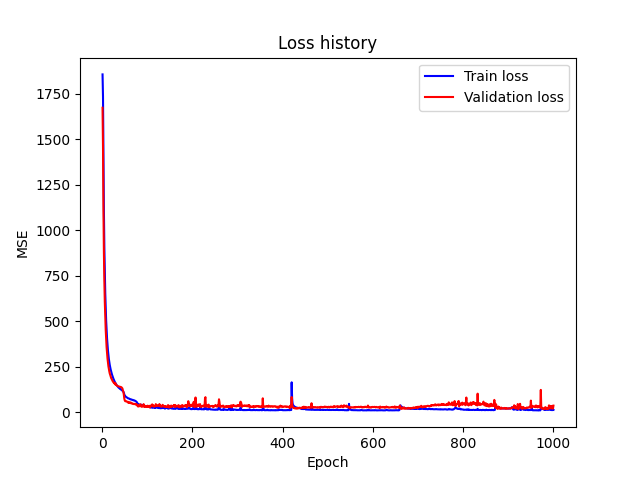

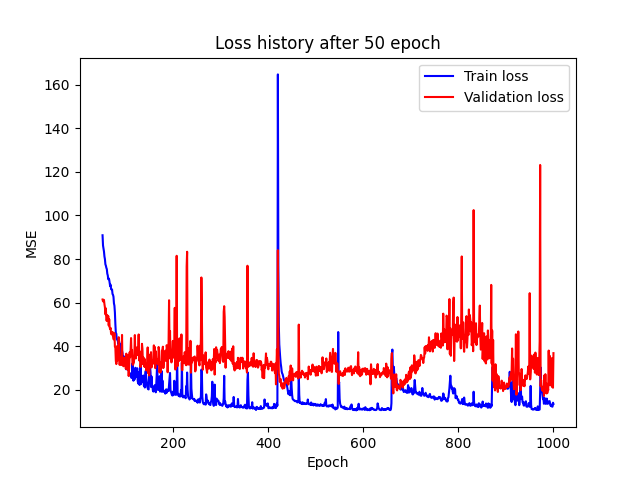

In [16]:
epochs_seq = list(range(1, num_epochs + 1))

plt.cla()
plt.title('Loss history')
plt.plot(epochs_seq, train_losses, color='b', label='Train loss')
plt.plot(epochs_seq, val_losses, color='r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

after_epoch = 50
plt.cla()
plt.title(f'Loss history after {after_epoch} epoch')
plt.plot(epochs_seq[after_epoch:], train_losses[after_epoch:], color='b', label='Train loss')
plt.plot(epochs_seq[after_epoch:], val_losses[after_epoch:], color='r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

# Evaluation

In [17]:
model = RnnCtrl(
    hidden_size=10,
    num_layers=2,
)
model.load_state_dict(torch.load(best_ckpt_path))
model = model.to(device)

MSE: 6055.166


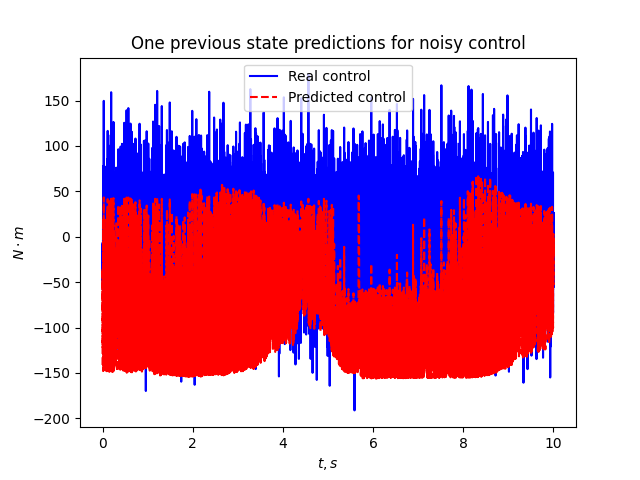

MSE: 5372.795


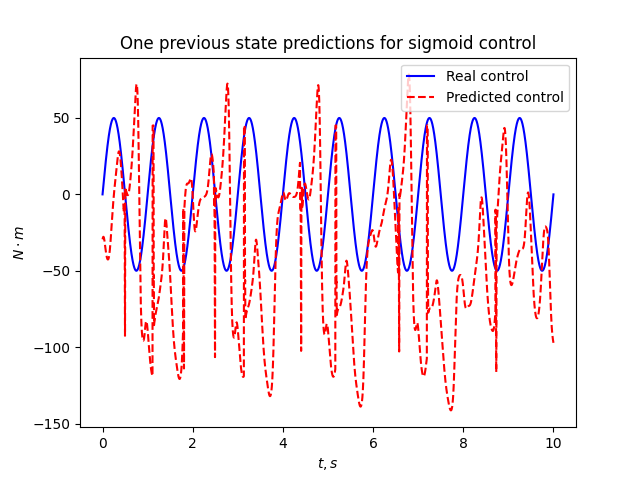

In [18]:
def plot_pred_1(df: pd.DataFrame,
                tr_model: torch.nn.Module,
                loss_fn: nn.Module,
                dev: torch.device,
                suffix: str):
    time_s = df['time'].values
    states_s = df[states_columns].values
    ctrl_s = df['ctrl'].values

    states_s = torch.tensor(states_s, dtype=torch.float32)
    states_s = torch.unsqueeze(states_s, dim=1)
    pred_c = tr_model(states_s.to(device))

    loss = loss_fn(torch.squeeze(pred_c), torch.tensor(ctrl_s).to(dev))
    print(f'MSE: {loss.item():.3f}')

    pred_c = pred_c.detach().cpu().numpy()
    plt.cla()
    plt.title(f'One previous state predictions for {suffix}')
    plt.plot(time_s, ctrl_s, color='b', label='Real control')
    plt.plot(time_s, pred_c, '--', color='r', label='Predicted control')
    plt.xlabel('$t, s$')
    plt.ylabel('$N \cdot m$')
    plt.legend(loc='best')
    plt.show()


plot_pred_1(first_half, model, loss_function, device, 'noisy control')
plot_pred_1(second_half, model, loss_function, device, 'sigmoid control')

MSE: 20.603


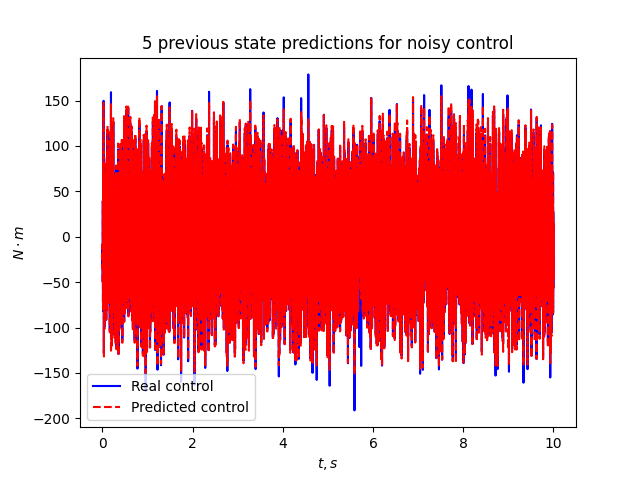

MSE: 21.430


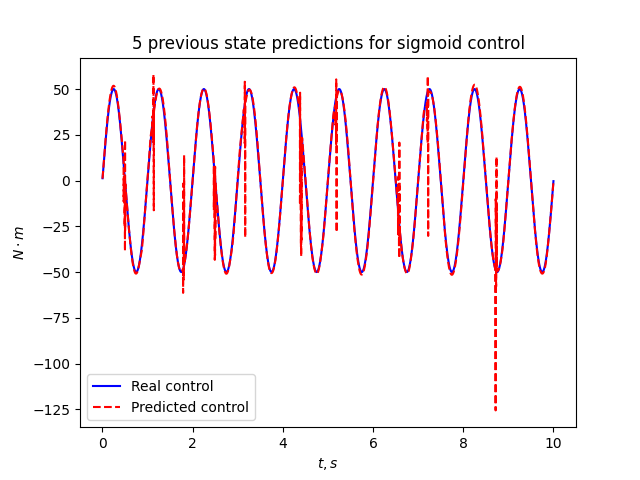

In [19]:
def plot_pred_2(df: pd.DataFrame,
                tr_model: torch.nn.Module,
                loss_fn: nn.Module,
                dev: torch.device,
                suffix: str):
    time_s = []
    states_s = []
    ctrl_s = []

    for i in range(num_of_prev_states, len(df)):
        sub = df.loc[i - num_of_prev_states: i - 1]
        states_s.append(sub[states_columns].values)
        ctrl_s.append(sub['ctrl'].loc[i - 1])
        time_s.append(sub['time'].loc[i - 1])

    states_s = torch.tensor(np.array(states_s), dtype=torch.float32)
    pred_c = tr_model(states_s.to(device))

    loss = loss_fn(torch.squeeze(pred_c), torch.tensor(ctrl_s).to(dev))
    print(f'MSE: {loss.item():.3f}')

    pred_c = pred_c.detach().cpu().numpy()
    plt.cla()
    plt.title(f'{num_of_prev_states} previous state predictions for {suffix}')
    plt.plot(time_s, ctrl_s, color='b', label='Real control')
    plt.plot(time_s, pred_c, '--', color='r', label='Predicted control')
    plt.xlabel('$t, s$')
    plt.ylabel('$N \cdot m$')
    plt.legend(loc='best')
    plt.show()


plot_pred_2(first_half, model, loss_function, device, 'noisy control')
plot_pred_2(second_half, model, loss_function, device, 'sigmoid control')